## Importing data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

rr_data = pd.DataFrame(pd.read_csv("data/data_RR_merged_20190108.csv"))
m_data = pd.DataFrame(pd.read_csv("data/data_M_merged_20190108.csv"))

In [2]:
# get indices with warmup rounds
rr_indexNames = rr_data[rr_data['round'] == 'warmup'].index
# delete these row indexes from the frame
rr_data.drop(rr_indexNames, inplace=True)

# get indices with warmup rounds
m_indexNames = m_data[m_data['round'] == 'warmup'].index
# delete these row indexes from the frame
m_data.drop(m_indexNames, inplace=True)

In [3]:
# preview rr data
rr_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,permutation,round,level,times_level_played_before,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991


In [4]:
# preview m data
m_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,round,level,times_level_played_before,incorrect,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
5959,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.590391,-1.496124,-9.477220,9.938119,0.096884
5960,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.562202,-1.482067,-9.485622,9.936721,0.086015
5961,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.534205,-1.468358,-9.493919,9.935430,0.111047
5962,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.506382,-1.455013,-9.502127,9.934255,0.091310
5963,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.478715,-1.442047,-9.510264,9.933209,0.055894


In [5]:
# returns values of dictionary in a list
def dict_to_x_y(dictionary):
    x_list = []
    y_list = []
    for key in dictionary:
        x_list.append(dictionary[key][0])
        y_list.append(dictionary[key][1])
    return x_list, y_list

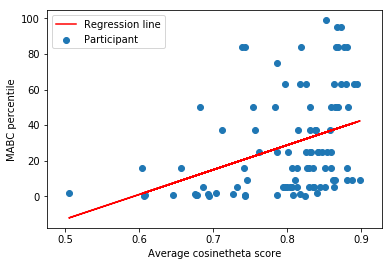

In [6]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]

# create a set of all unique children
children_ids = set(subdata['ID'])

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_dictionary = {}
for child_id in children_ids:
    avg_ct = subdata.loc[subdata['ID'] == child_id]['costheta'].mean()
    mabc_perc = subdata.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_dictionary[child_id] = (avg_ct, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_ct, mabc = dict_to_x_y(subdata_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ct, mabc)
avg_ct_slope = [i * slope for i in avg_ct]

# scatter plot with mabc
plt.scatter(avg_ct, mabc, label='Participant')
plt.plot(avg_ct, intercept + avg_ct_slope, 'r', label='Regression line')
plt.xlabel("Average cosinetheta score")
plt.ylabel("MABC percentile")
plt.legend()


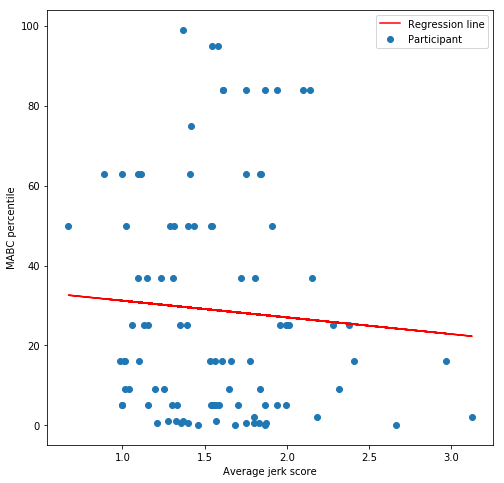

In [7]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_jerk, mabc)
avg_jerk_slope = [i * slope for i in avg_jerk]

# scatter plot with mabc
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(avg_jerk, mabc, label='Participant')
plt.plot(avg_jerk, intercept + avg_jerk_slope, 'r', label='Regression line')
plt.xlabel("Average jerk score")
plt.ylabel("MABC percentile")
plt.legend()


## Tijd fixen

In [8]:
rr_data_time = rr_data

times = []
for child_id in children_ids:
    child_frame = rr_data.loc[subdata['ID'] == child_id]
    mintime = child_frame['python_tijd'].min()
    fixedtime = child_frame['python_tijd'] - mintime
    times.append(fixedtime.values)
    
    
realtimes = [item for sublist in times for item in sublist]

rr_data_time.insert(4, 'real_time', realtimes)


In [9]:
rr_data_time.head(10)

,ID,index_runner,side_runner,square_runner,real_time,python_tijd,spel,permutation,round,level,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,0.00,1.497942e+09,RR,1,level_A,0,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,0.01,1.497942e+09,RR,1,level_A,0,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,0.03,1.497942e+09,RR,1,level_A,0,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991
6272,101,23,2,5,0.04,1.497942e+09,RR,1,level_A,0,...,0.898858,37.0,0,1,7.009042,10.063323,0.584044,-0.247610,10.083298,0.129659
6273,101,23,2,5,0.05,1.497942e+09,RR,1,level_A,0,...,0.896844,37.0,0,1,7.009042,10.064244,0.604002,-0.261799,10.085751,0.093369
6274,101,23,2,5,0.06,1.497942e+09,RR,1,level_A,0,...,0.896844,37.0,0,1,7.009042,10.064714,0.622877,-0.275889,10.087743,0.069849
6275,101,23,2,5,0.08,1.497942e+09,RR,1,level_A,0,...,0.895630,37.0,0,1,7.009042,10.064747,0.640736,-0.289878,10.089286,0.036418
6276,101,23,2,5,0.09,1.497942e+09,RR,1,level_A,0,...,0.893947,37.0,0,1,7.009042,10.064356,0.657642,-0.303760,10.090393,0.009958


# Easy diagrams for report

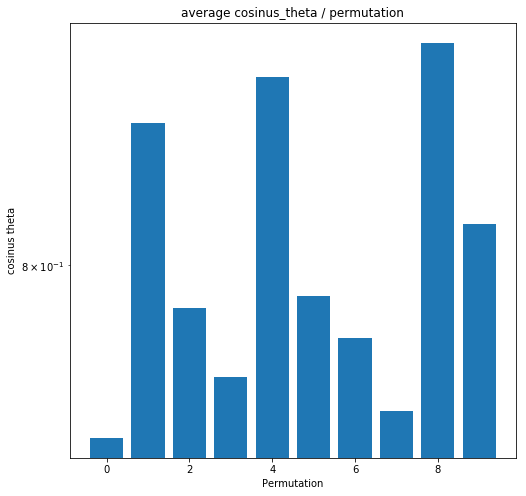

In [10]:
# BAR CHART average cosinus_theta / permutation
permutations = sorted(rr_data['permutation'].unique())

means = []
for p in permutations:
    thispermutation = rr_data.loc[rr_data['permutation'] == p]
    means.append(thispermutation['costheta'].mean())
    
    
plt.bar(permutations, means, log=True)
plt.xlabel('Permutation')
plt.ylabel('cosinus theta')
plt.title('average cosinus_theta / permutation')
plt.savefig('plots/cosine_permutation.png', dpi=100)
plt.show()

In [11]:
## get dataframe with only IDs for Average age
ids = rr_data['ID'].unique()
rr_data_id = rr_data.groupby('ID').first()
ages = list(rr_data_id['age_precise'])
print('The average age of all participants is {}'.format(np.mean(ages)))

percs = list(rr_data_id['mabc_percentile_score'])

The average age of all participants is 7.829102126212949


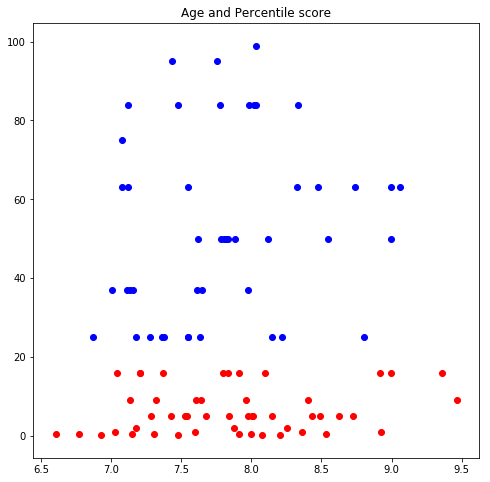

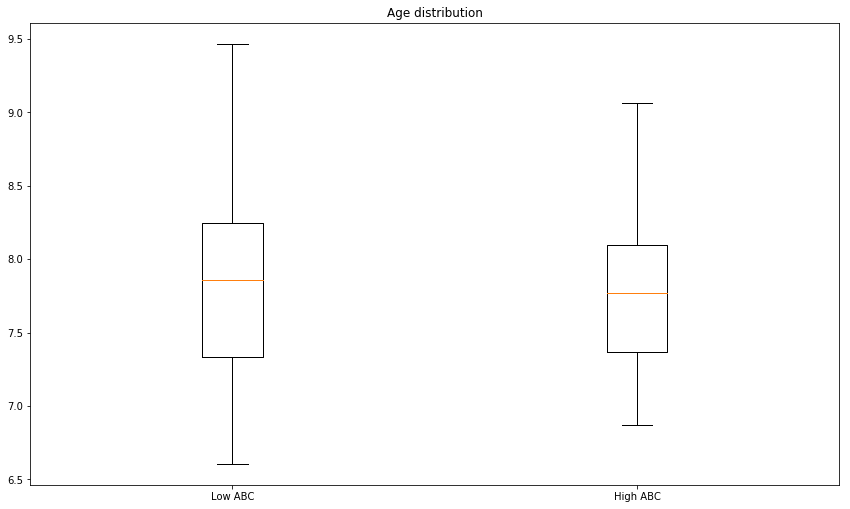

In [12]:
# scatter plot ages
ages_low = []
ages_high = []
for age, perc in zip(ages, percs):
    if perc <= 17:
        ages_low.append(age)
        plt.scatter(age, perc, color='red')
    else:
        ages_high.append(age)
        plt.scatter(age, perc, color='blue')
 
plt.title('Age and Percentile score')
plt.rcParams["figure.figsize"] = (5.5, 12.5)
# uncomment for save
# plt.savefig('plots/scatter_ages.png', dpi=100)
plt.show()
    
# boxplot ages
my_dict = {'Low ABC': ages_low, 'High ABC': ages_high}

fig, ax = plt.subplots()
plt.title('Age distribution')
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
fig.set_size_inches(14.5, 8.5)
# uncomment for save
# fig.savefig('plots/age_percentile.png', dpi=100)



Text(0.5,1,'Gender distribution')

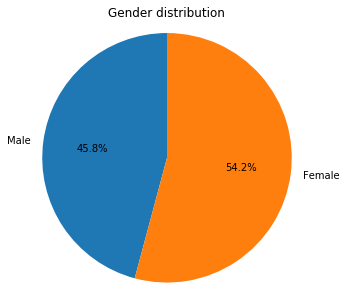

In [13]:
# pie chart of genders
genderlist = list(rr_data_id.groupby('gender').size())
labels = 'Male', 'Female'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(genderlist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Gender distribution')
# uncomment for save:
# fig1.savefig('plots/gender_pie.png', dpi=100)



Text(0.5,1,'mABC test result')

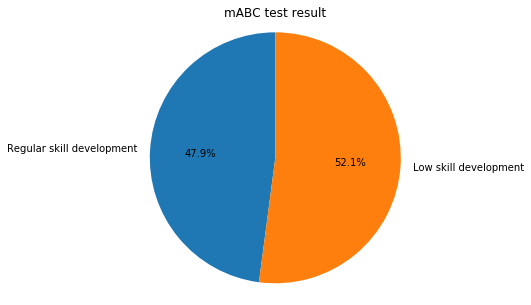

In [14]:
# pie chart of MABC score
abclist = list(rr_data_id.groupby('mabc_binary_score').size())
labels = 'Regular skill development', 'Low skill development'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(abclist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('mABC test result')
# uncomment for save:
# fig1.savefig('plots/mABC_pie.png', dpi=100)

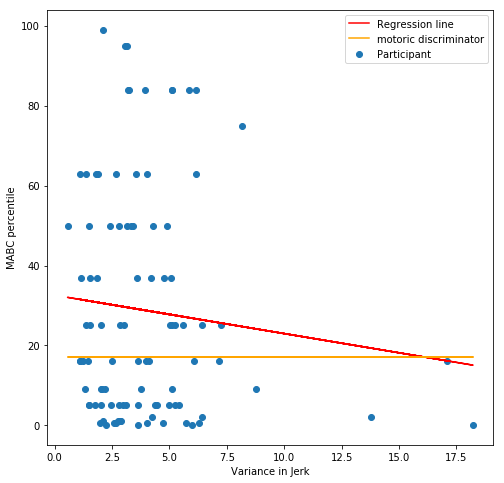

In [15]:
# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    var_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].var()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (var_jerk, mabc_perc)

var_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(var_jerk, mabc)
var_jerk_slope = [i * slope for i in var_jerk]

# scatter plot with mabc
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(var_jerk, mabc, label='Participant')
plt.plot(var_jerk, intercept + var_jerk_slope, 'r', label='Regression line')
plt.plot(var_jerk, [17 for i in range(len(var_jerk))], 'orange', label='motoric discriminator')
plt.xlabel("Variance in Jerk")
plt.ylabel("MABC percentile")
plt.legend()


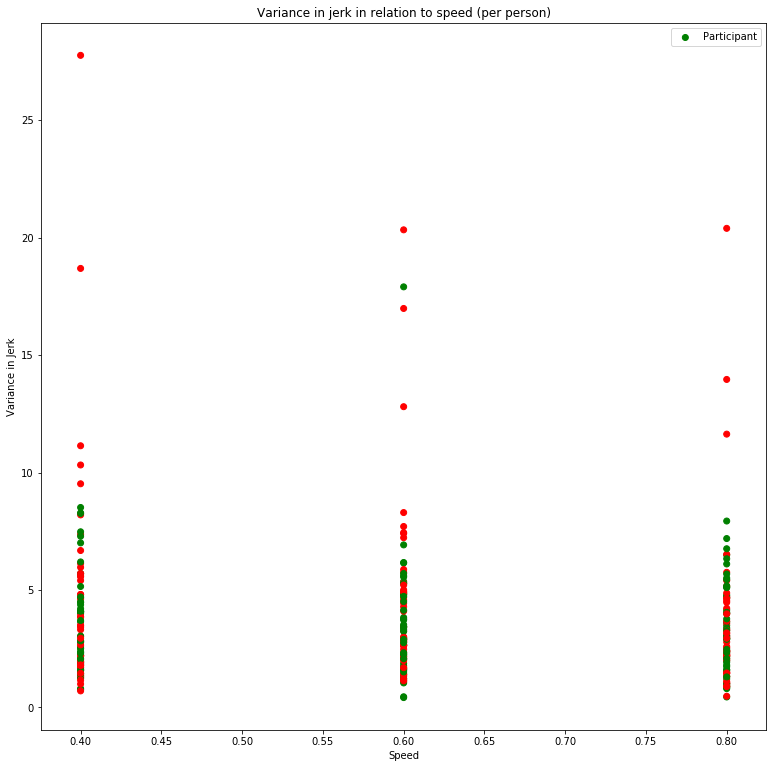

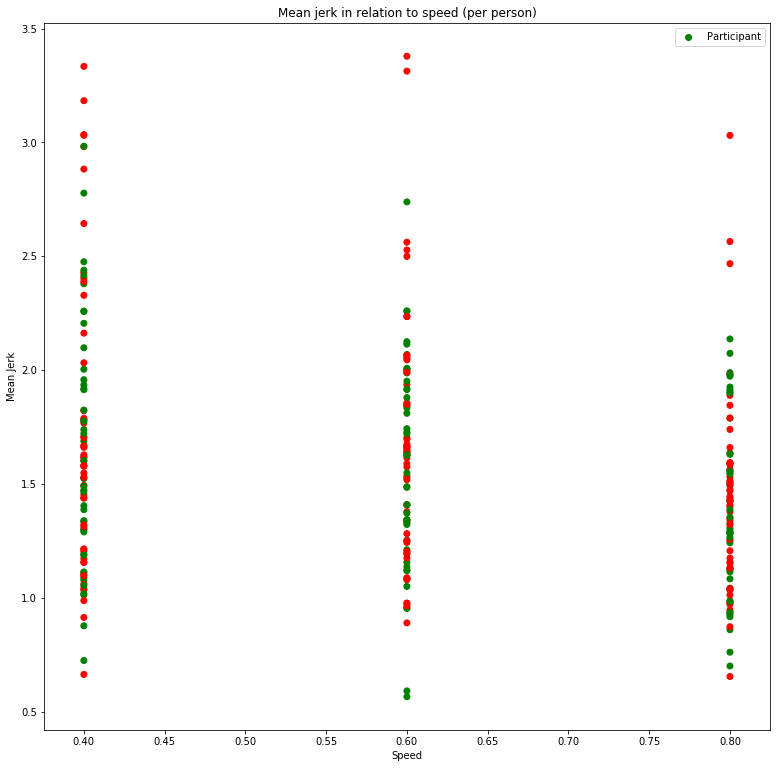

In [16]:
# create a dataframe containing this data
subdata_jerk_speed = rr_data[['ID', 'jerk', 'mabc_binary_score', 'snelheid', 'round']]

speedset = set(subdata_jerk_speed['snelheid'])


subdata_jerk_speed.head(10)


var_jerk_list = []
mean_jerk_list = []
speed_list = []
mabc_list = []

# onderpresterende kinderen reacting to snelheid en jerk
for child_id in children_ids:
    mabc = subdata_jerk_speed.loc[subdata_jerk_speed['ID'] == child_id]['mabc_binary_score'].mean()
    for speed in speedset:
        var_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].var()
        mean_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].mean()
#         print(child_id, "has", mean_jerk, var_jerk, " on speed", speed, ". His MABS is:", mabc)
        speed_list.append(speed)
        var_jerk_list.append(var_jerk)
        mean_jerk_list.append(mean_jerk)
        mabc_list.append(mabc)
#     print()

color_list = ['green' if int(i) is 0 else 'red' for i in mabc_list]

plt.rcParams["figure.figsize"] = (13, 13)
plt.scatter(speed_list, var_jerk_list, color=color_list, label='Participant')
plt.title("Variance in jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Variance in Jerk")
plt.show()

plt.rcParams["figure.figsize"] = (13, 13)
plt.scatter(speed_list, mean_jerk_list, color=color_list, label='Participant')
plt.title("Mean jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Mean Jerk")
plt.show()
    

In [17]:
rr_data_time.shape

(1737312, 22)

In [18]:
# shuffle this list
shuffled_kids = random.sample(list(children_ids), len(list(children_ids)))

# 56 kinderen training
# 20 kinderen
# 20 kinderen
training_kids = shuffled_kids[:56]
val_kids = shuffled_kids[56:76]
testing_kids = shuffled_kids[76:96]


In [19]:
rr_training_data = rr_data.loc[rr_data['ID'].isin(training_kids)]
rr_val_data = rr_data.loc[rr_data['ID'].isin(val_kids)]
rr_testing_data = rr_data.loc[rr_data['ID'].isin(testing_kids)]

In [20]:
# conventional way to import seaborn
import seaborn as sns

# allow plots to appear within the notebook
%matplotlib inline

In [ ]:
average_per_kid = []

subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)